# FELADAT
A feladatod, hogy pontositsd az elorejelzesinket a kovetkezo heti napi bevetelekrol. Ehhez rendelkezesedre all az alabbi adathalmaz, ami tartalmazza az ugyfel- es datumszintu beveteleket. Ennek segitsegevel keszits el legalabb 2 fele elorejelzesi modellt, majd ertekeld ki oket (legalabb 3 honapos intervallumon), hogy mi a varhato pontossag, ha elesben hasznalnank oket.<br>
<br>
A jelenlegi egyszeru elorejelzesi modellunk az adott napra mindig a 2 hettel ezelotti ertek. Keszitsd el ezt is, majd nezd meg a te modelleid ehhez kepest hogy teljesitenek.
<br>
Az elorejelzeseknek minden penteken kell elkeszulnie, a legfrissebb elerheto adatod pedig az elozo nap (csutortok) bevetelei, igy ez alapjan keszitsd es ertekeld is ki a modelleid!
<br>
### Peldaul:
- 2011.05.06 (penteken) elkeszitendo forecasthoz
    - lehetseges tanito intervallum: 2010-04-01 - 2011.05.05
    - forecast intervallum: 2011.05.09 - 2011.05.15

In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
import math


In [4]:
df = pd.read_csv('./DataSet_Tesco5000_withDaynum.csv')

In [8]:
df.head()

,customer_id,visit_date,visit_spend,daynum
0,2,2010-04-01,5.97,0
167642,2227,2010-04-01,10.46,0
474230,5883,2010-04-01,123.93,0
474488,5886,2010-04-01,61.02,0
166892,2220,2010-04-01,19.57,0


In [8]:
df.dtypes

customer_id             int64
visit_date     datetime64[ns]
visit_spend           float64
daynum                  int64
dtype: object

In [7]:
# sort by daynum
df = df.sort_values(by=['daynum'], ascending=True)

In [5]:
df['visit_date'] = pd.to_datetime(df['visit_date'])

<Axes: xlabel='visit_date'>

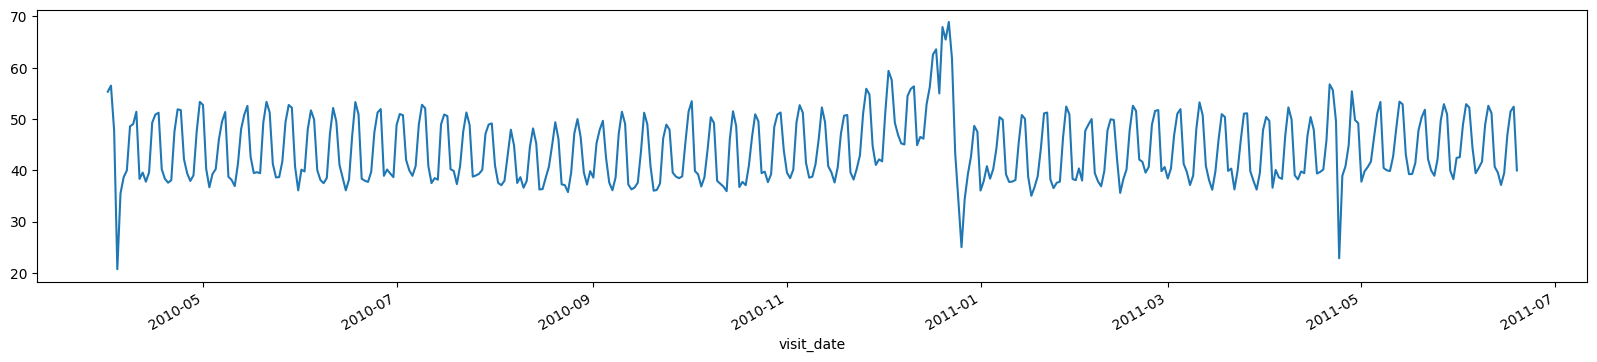

In [15]:
# histogram of visit_spend
plt.figure(figsize=(20,4))
df.groupby('visit_date')['visit_spend'].mean().plot()
#plt.plot(df['daynum'],df['visit_spend'])



<Axes: xlabel='visit_date'>

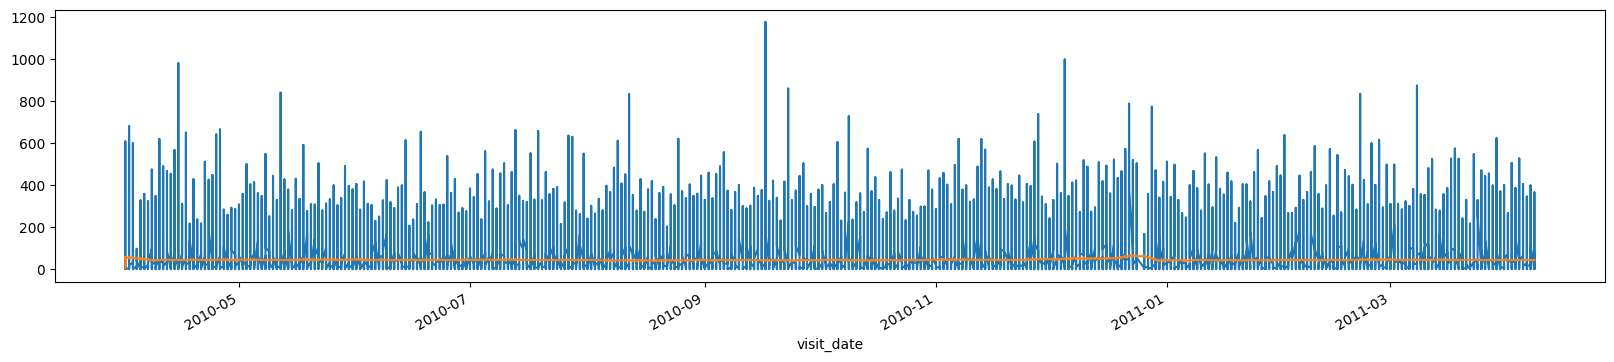

In [20]:
df.set_index('visit_date')['visit_spend'][:500000].plot(figsize=(20, 4))
df.set_index('visit_date')['visit_spend'].rolling('7d').mean()\
[:500000].plot(figsize=(20, 4))

In [39]:
# 3 month test data -> 126079 rows
df[df['visit_date'] >= '2011-03-18']

,customer_id,visit_date,visit_spend,daynum,weeknum
21260,288,2011-03-18,89.96,351,49
25947,349,2011-03-18,7.25,351,49
557535,6913,2011-03-18,40.50,351,49
547506,6771,2011-03-18,64.82,351,49
496695,6121,2011-03-18,10.92,351,49
...,...,...,...,...,...
571612,7071,2011-06-19,21.98,444,62
89206,1236,2011-06-19,36.09,444,62
292883,3731,2011-06-19,58.90,444,62
8078,96,2011-06-19,16.49,444,62


In [35]:
df['weeknum']=df['daynum'].apply(lambda x: ((x-4)//7))

In [43]:
cust_df = pd.DataFrame({'daynum':df['daynum'].unique()})
stat = df.groupby("daynum",as_index=False).agg({'visit_spend':'sum'})
cust_df=cust_df.merge(stat,on='daynum',how='left')

In [52]:
stat = df.groupby("daynum",as_index=False).agg({'weeknum':'min'})
cust_df=cust_df.merge(stat,on='daynum',how='left')

In [54]:
# rename columns
cust_df.columns = ['daynum','day_spend','weeknum']
cust_df

,daynum,day_spend,weeknum
0,0,102625.86,-1
1,1,82660.90,-1
2,2,78081.71,-1
3,3,4411.05,-1
4,4,38144.77,0
...,...,...,...
439,440,51252.38,62
440,441,68920.34,62
441,442,80762.94,62
442,443,81009.66,62


In [55]:
stat = cust_df.groupby("weeknum",as_index=False).agg({'day_spend':'sum'})
cust_df=cust_df.merge(stat,on='weeknum',how='left')

In [57]:
cust_df.columns = ['daynum','day_spend','weeknum','week_spend']
cust_df

,daynum,day_spend,weeknum,week_spend
0,0,102625.86,-1,267779.52
1,1,82660.90,-1,267779.52
2,2,78081.71,-1,267779.52
3,3,4411.05,-1,267779.52
4,4,38144.77,0,403921.32
...,...,...,...,...
439,440,51252.38,62,411613.84
440,441,68920.34,62,411613.84
441,442,80762.94,62,411613.84
442,443,81009.66,62,411613.84


In [62]:
df[df['visit_date'] >= '2011-03-18']

,customer_id,visit_date,visit_spend,daynum,weeknum
21260,288,2011-03-18,89.96,351,49
25947,349,2011-03-18,7.25,351,49
557535,6913,2011-03-18,40.50,351,49
547506,6771,2011-03-18,64.82,351,49
496695,6121,2011-03-18,10.92,351,49
...,...,...,...,...,...
571612,7071,2011-06-19,21.98,444,62
89206,1236,2011-06-19,36.09,444,62
292883,3731,2011-06-19,58.90,444,62
8078,96,2011-06-19,16.49,444,62


In [63]:
# the first 350 days as training data, the rest 3 months as test data
train_df = cust_df[cust_df['daynum'] <= 350]
test_df = cust_df[cust_df['daynum'] > 352]

ARIMA MODEL

In [66]:
len(train_df), len(test_df)

(350, 94)

In [103]:
test = test_df['day_spend'].values

In [179]:
history = [x for x in train_df['day_spend']]

In [185]:

# make first prediction
#predictions = list()
model = ARIMA(history, order=(30,0,1))
model_fit = model.fit()
yhat = model_fit.get_forecast(3)
#predictions.append(yhat)
print(yhat.predicted_mean)
print(test_df[:3]['day_spend'])
#train_df.append(y[0])

f:\Egyetem\python_mate_laptop\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[82021.64238208 72229.7907459  35509.6640805 ]
350    84938.65
351    72955.89
352    34898.25
Name: day_spend, dtype: float64


In [148]:
predictions = list()

In [149]:
# rolling forecasts
for i in range(0, 13):
    
    # predict
    model = ARIMA(history, order=(30,0,1))
    model_fit = model.fit()
    yhat = model_fit.get_forecast(10)
    # add next week prediction to the list
    predictions.append(yhat.predicted_mean[3:10])
    # observation
    obs = test[i*7:(i+1)*7].tolist()
    for i in range(0,7):
        history.append(obs[i])
    

f:\Egyetem\python_mate_laptop\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
f:\Egyetem\python_mate_laptop\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\Egyetem\python_mate_laptop\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\Egyetem\python_mate_laptop\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\Egyetem\python_mate_laptop\lib\site-packages\statsm

In [155]:
test = test[3:94]
test

array([ 52625.26,  46095.9 ,  52160.25,  69337.81,  83723.53,  77938.96,
        34827.78,  49122.15,  46457.21,  52810.02,  74968.1 ,  84015.53,
        80413.48,  33228.2 ,  50214.54,  50973.2 ,  50861.3 ,  71002.93,
        85872.91,  74329.23,  33989.37,  52677.13,  52933.04,  51548.28,
        68076.95,  81272.71,  75231.83,  32714.44,  52691.41,  52677.67,
        66887.57, 105552.12,  78410.81,  83078.07,   5278.59,  43052.06,
        60615.53,  63154.46, 106141.85,  53721.82,  75565.6 ,  32523.66,
        41144.43,  58689.62,  56881.9 ,  69178.06,  81663.77,  80080.53,
        34789.49,  50080.77,  51130.2 ,  56198.2 ,  74007.87,  85149.84,
        80314.69,  37581.15,  50475.14,  51412.74,  56778.73,  70685.16,
        81841.03,  77665.59,  39312.76,  51652.59,  51048.1 ,  57801.98,
        79657.62,  87864.61,  77142.74,  32983.13,  41824.9 ,  59223.1 ,
        56714.83,  71603.66,  81831.17,  76071.21,  37967.97,  52323.14,
        53625.3 ,  52401.03,  70399.43,  82286.19, 

In [156]:
# predictions to one dimension
pred = []
for i in range(0,13):
    for j in range(0,7):
        pred.append(predictions[i][j])

In [164]:
#float to int
test_int = [int(i) for i in test]
pred_int = [int(i) for i in pred]

In [192]:
# report performance
for i in range (0,13):
    print('Week '+str(i+1)+' MAE: '+str(mean_absolute_error(test[i*7:(i+1)*7], pred[i*7:(i+1)*7])))
    print('Week '+str(i+1)+' RMSE: '+str(math.sqrt(mean_squared_error(test[i*7:(i+1)*7], pred[i*7:(i+1)*7]))))
    


Week 1 MAE: 1534.2559207990178
Week 1 RMSE: 1934.8771739277006
Week 2 MAE: 3164.607505985948
Week 2 RMSE: 3994.8627823151423
Week 3 MAE: 2095.944170913296
Week 3 RMSE: 2681.756450886183
Week 4 MAE: 2382.7428733039014
Week 4 RMSE: 2818.3144995768394
Week 5 MAE: 14138.31833249867
Week 5 RMSE: 19998.212187749337
Week 6 MAE: 10641.73698863601
Week 6 RMSE: 14620.457077696452
Week 7 MAE: 9940.253954026037
Week 7 RMSE: 13945.000587119914
Week 8 MAE: 6413.561682750025
Week 8 RMSE: 8648.25852351401
Week 9 MAE: 8203.43758751662
Week 9 RMSE: 9461.439844209426
Week 10 MAE: 4962.776441051837
Week 10 RMSE: 6581.462495142145
Week 11 MAE: 4021.247929492668
Week 11 RMSE: 4311.624157074127
Week 12 MAE: 2718.475612674156
Week 12 RMSE: 3241.9197768317285
Week 13 MAE: 3438.1532263064737
Week 13 RMSE: 3753.6641790193353


In [177]:
test_df.index[3:]

Index([353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366,
       367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
       381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
       395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408,
       409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422,
       423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
       437, 438, 439, 440, 441, 442, 443],
      dtype='int64')

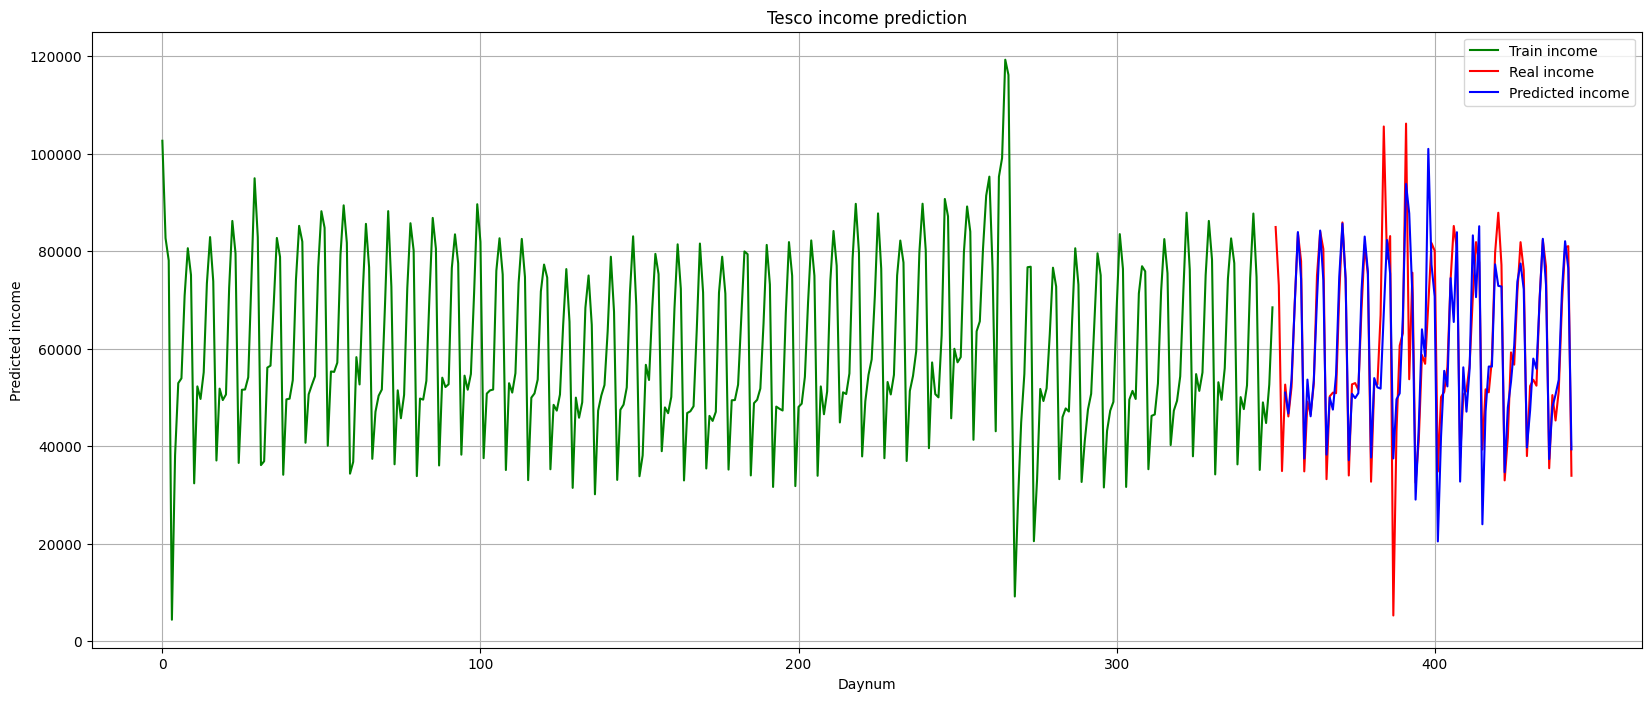

In [178]:
# evaluate forecasts
plt.figure(figsize=(20,8))
plt.plot(cust_df.index[0:350], cust_df['day_spend'].head(350), color='green', label = 'Train income')
plt.plot(test_df.index, test_df['day_spend'], color = 'red', label = 'Real income')
plt.plot(test_df.index[3:], pred, color = 'blue', label = 'Predicted income')
plt.title('Tesco income prediction')
plt.xlabel('Daynum')
plt.ylabel('Predicted income')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

Simple prediction

In [204]:
# the "simple prediction"
# prediction will be the same as two weeks before
predictions_simple = cust_df['day_spend'].shift(14).tail(13*7)
predictions_simple = predictions_simple.tolist()

In [211]:
# report performance simple modell
# except three weeks(2,9,10) the ARIMA model is better
for i in range (0,13):
    print('Week '+str(i+1)+' MAE: '+str(mean_absolute_error(test[i*7:(i+1)*7], predictions_simple[i*7:(i+1)*7])))
    print('Week '+str(i+1)+' RMSE: '+str(math.sqrt(mean_squared_error(test[i*7:(i+1)*7], predictions_simple[i*7:(i+1)*7]))))
    
    

Week 1 MAE: 2451.635714285716
Week 1 RMSE: 2995.8789905206236
Week 2 MAE: 2653.845714285713
Week 2 RMSE: 3864.035301339779
Week 3 MAE: 2407.087142857145
Week 3 RMSE: 2736.3280481774964
Week 4 MAE: 3803.1328571428558
Week 4 RMSE: 4444.751330854019
Week 5 MAE: 14239.788571428571
Week 5 RMSE: 18578.2591399994
Week 6 MAE: 13579.15428571429
Week 6 RMSE: 18877.4316901759
Week 7 MAE: 14242.865714285716
Week 7 RMSE: 18834.323441823668
Week 8 MAE: 13834.125714285718
Week 8 RMSE: 17953.149247613517
Week 9 MAE: 3619.047142857144
Week 9 RMSE: 4908.01755005449
Week 10 MAE: 2770.3128571428597
Week 10 RMSE: 3285.0782714984803
Week 11 MAE: 2913.1471428571417
Week 11 RMSE: 4488.504456550247
Week 12 MAE: 3756.8785714285727
Week 12 RMSE: 4771.884558882372
Week 13 MAE: 5827.031428571428
Week 13 RMSE: 7054.725179440269


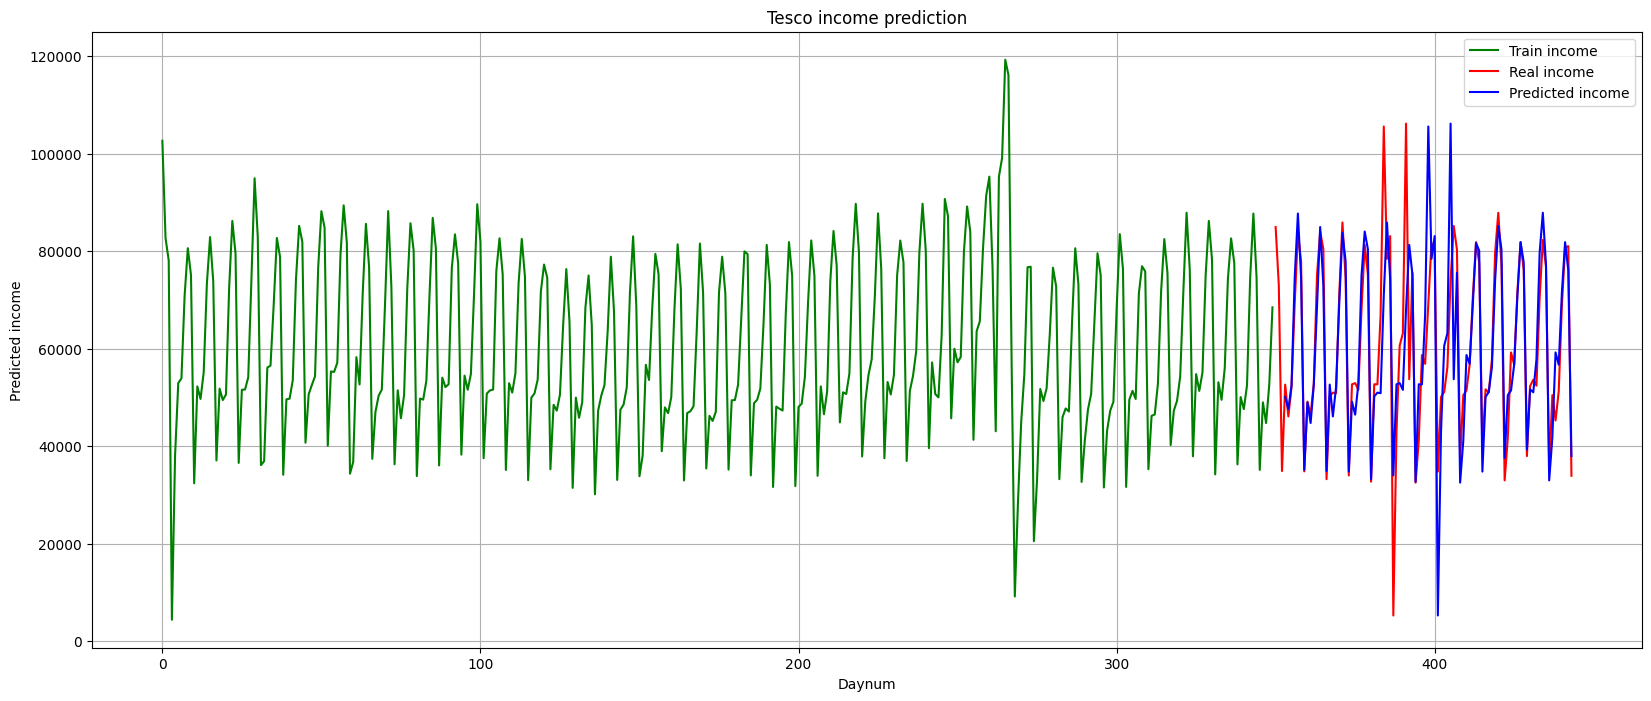

In [212]:
# evaluate forecasts simple model
plt.figure(figsize=(20,8))
plt.plot(cust_df.index[0:350], cust_df['day_spend'].head(350), color='green', label = 'Train income')
plt.plot(test_df.index, test_df['day_spend'], color = 'red', label = 'Real income')
plt.plot(test_df.index[3:], predictions_simple, color = 'blue', label = 'Predicted income')
plt.title('Tesco income prediction')
plt.xlabel('Daynum')
plt.ylabel('Predicted income')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

In [210]:
len(predictions_simple)

91

SARIMA

In [198]:
%pip install pmdarima

   ---------------------------------------- 0.0/615.0 kB ? eta -:--:--
   ------------------------------ --------- 471.0/615.0 kB 9.8 MB/s eta 0:00:01
   ---------------------------------------- 615.0/615.0 kB 7.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [216]:
# import sarima

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

C:\Users\Máté\AppData\Local\Temp\ipykernel_26452\3099952657.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

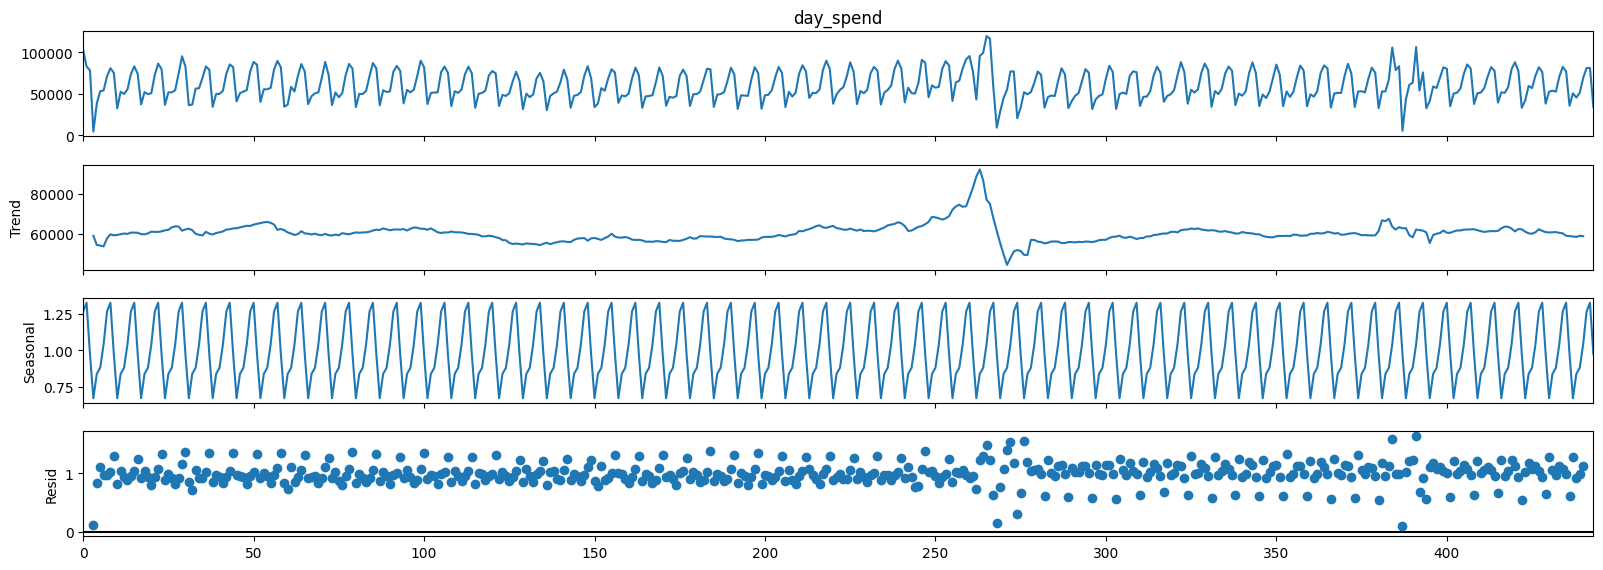

In [196]:
#seasonal pattern
result = seasonal_decompose(cust_df["day_spend"], model='multiplicative', period=7)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(18, 6)
fig.show()

In [ ]:
# find the p, d, and q values
# m is the seasonal periodicity of weekly data
model = auto_arima(cust_df['day_spend'], seasonal=True, m=7, suppress_warnings=True)
print(model.order)

In [268]:
# make first prediction
#predictions = list()
model = SARIMAX(history, order=(4,0,2), seasonal_order=(4,0,2,7))
model_fit = model.fit()
yhat = model_fit.get_forecast(7)
#predictions.append(yhat)
print(yhat.predicted_mean)
print(test_df[:7]['day_spend'])
#train_df.append(y[0])

f:\Egyetem\python_mate_laptop\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[47791.85316354 45824.09745959 50484.29030783 69237.4242921
 79984.13893308 78024.78391019 33478.28973462]
350    84938.65
351    72955.89
352    34898.25
353    52625.26
354    46095.90
355    52160.25
356    69337.81
Name: day_spend, dtype: float64


In [355]:
test = test_df['day_spend'].values
history = [x for x in train_df['day_spend']]
predictions2 = list()
# rolling forecasts
for i in range(0, 13):
    
    # predict
    model = SARIMAX(history, order=(4,0,2), seasonal_order=(4,0,2,7))
    model_fit = model.fit()
    yhat = model_fit.get_forecast(10)
    # add next week prediction to the list
    predictions2.append(yhat.predicted_mean[3:10])
    # observation
    obs = test[i*7:(i+1)*7].tolist()
    for i in range(0,7):
        history.append(obs[i])

f:\Egyetem\python_mate_laptop\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
f:\Egyetem\python_mate_laptop\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
f:\Egyetem\python_mate_laptop\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\Egyetem\python_mate_laptop\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\Egyetem\python_mate_laptop\lib\site-packag

In [356]:
test = test[3:94]
test

array([ 52625.26,  46095.9 ,  52160.25,  69337.81,  83723.53,  77938.96,
        34827.78,  49122.15,  46457.21,  52810.02,  74968.1 ,  84015.53,
        80413.48,  33228.2 ,  50214.54,  50973.2 ,  50861.3 ,  71002.93,
        85872.91,  74329.23,  33989.37,  52677.13,  52933.04,  51548.28,
        68076.95,  81272.71,  75231.83,  32714.44,  52691.41,  52677.67,
        66887.57, 105552.12,  78410.81,  83078.07,   5278.59,  43052.06,
        60615.53,  63154.46, 106141.85,  53721.82,  75565.6 ,  32523.66,
        41144.43,  58689.62,  56881.9 ,  69178.06,  81663.77,  80080.53,
        34789.49,  50080.77,  51130.2 ,  56198.2 ,  74007.87,  85149.84,
        80314.69,  37581.15,  50475.14,  51412.74,  56778.73,  70685.16,
        81841.03,  77665.59,  39312.76,  51652.59,  51048.1 ,  57801.98,
        79657.62,  87864.61,  77142.74,  32983.13,  41824.9 ,  59223.1 ,
        56714.83,  71603.66,  81831.17,  76071.21,  37967.97,  52323.14,
        53625.3 ,  52401.03,  70399.43,  82286.19, 

In [357]:
# predictions to one dimension
pred2 = []
for i in range(0,13):
    for j in range(0,7):
        pred2.append(predictions2[i][j])

In [358]:
# report performance
for i in range (0,13):
    print('Week '+str(i+1)+' MAE: '+str(mean_absolute_error(test[i*7:(i+1)*7], pred2[i*7:(i+1)*7])))
    print('Week '+str(i+1)+' RMSE: '+str(math.sqrt(mean_squared_error(test[i*7:(i+1)*7], pred2[i*7:(i+1)*7]))))

Week 1 MAE: 2357.285147166286
Week 1 RMSE: 2810.6301964742474
Week 2 MAE: 3615.015724323327
Week 2 RMSE: 4373.414287617146
Week 3 MAE: 2217.1719509411205
Week 3 RMSE: 2635.1336626104744
Week 4 MAE: 1801.758317770201
Week 4 RMSE: 2302.503511139148
Week 5 MAE: 13946.053367273666
Week 5 RMSE: 19696.286903741537
Week 6 MAE: 11607.693242262192
Week 6 RMSE: 16283.170254552413
Week 7 MAE: 7858.145228312705
Week 7 RMSE: 11981.978981692011
Week 8 MAE: 9155.670128440632
Week 8 RMSE: 11819.519863644116
Week 9 MAE: 4258.799597217117
Week 9 RMSE: 5562.782521569325
Week 10 MAE: 4504.776542243369
Week 10 RMSE: 6261.94056658521
Week 11 MAE: 4193.04396228564
Week 11 RMSE: 5013.204200165393
Week 12 MAE: 3820.6384427565667
Week 12 RMSE: 4271.337301717711
Week 13 MAE: 3230.0558067782986
Week 13 RMSE: 3981.6569672865608


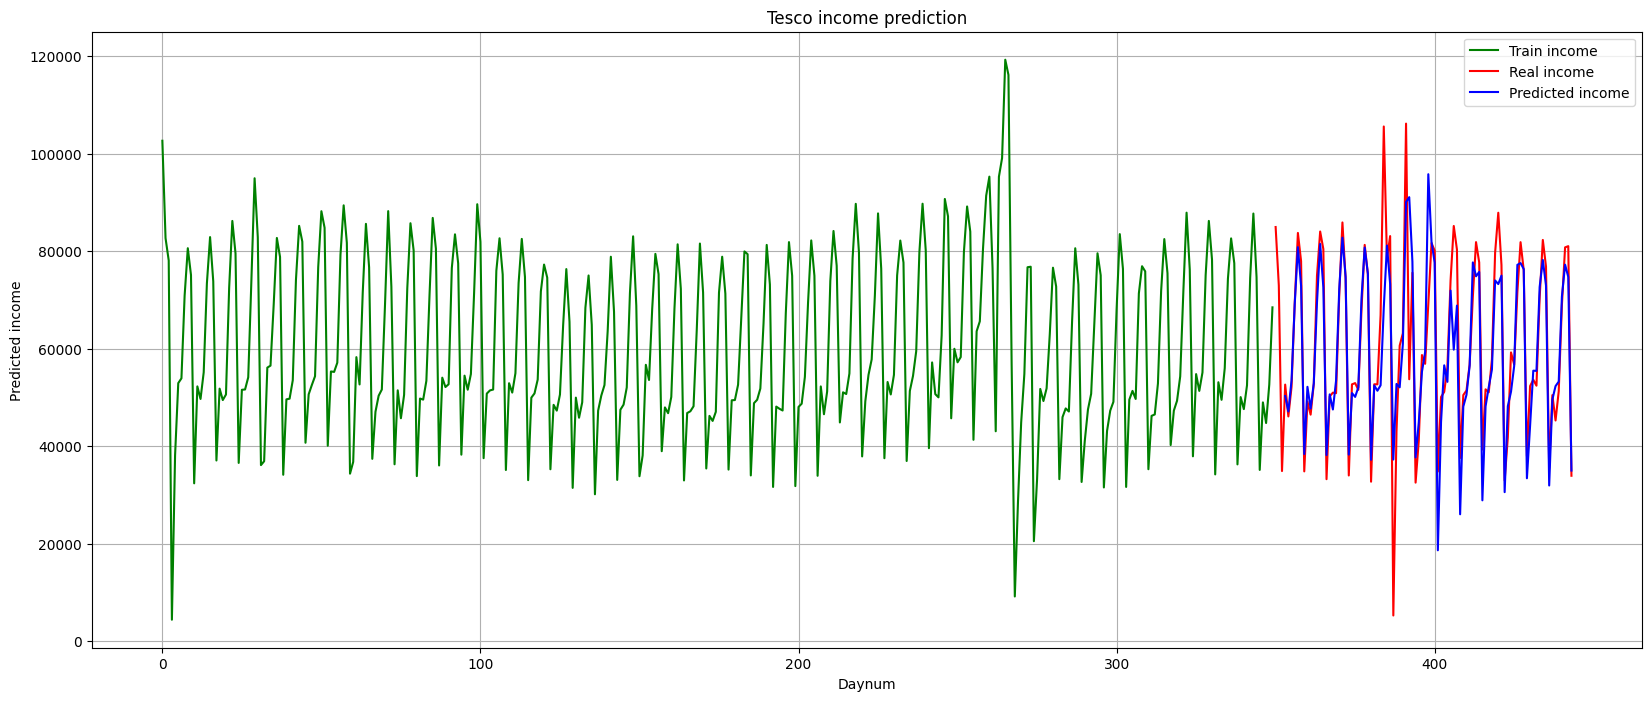

In [359]:
# evaluate forecasts simple model
plt.figure(figsize=(20,8))
plt.plot(cust_df.index[0:350], cust_df['day_spend'].head(350), color='green', label = 'Train income')
plt.plot(test_df.index, test_df['day_spend'], color = 'red', label = 'Real income')
plt.plot(test_df.index[3:], pred2, color = 'blue', label = 'Predicted income')
plt.title('Tesco income prediction')
plt.xlabel('Daynum')
plt.ylabel('Predicted income')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

ETS

In [250]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [282]:
# make first prediction
#predictions = list()
history = [x for x in train_df['day_spend']]
model = ETSModel(
    history,
    error="add",
    trend="add",
    seasonal="add",
    damped_trend=False,
    seasonal_periods=7,
)
model_fit = model.fit()
yhat = model_fit.predict(350,359)
#predictions.append(yhat)
print(yhat)
print(test_df[:10]['day_spend'])
#train_df.append(y[0])

[84580.80507806 73957.15838857 33857.28316772 48271.83368731
 44927.45330496 52035.99251635 69951.16765733 84644.02663959
 74020.3799501  33920.50472924]
350    84938.65
351    72955.89
352    34898.25
353    52625.26
354    46095.90
355    52160.25
356    69337.81
357    83723.53
358    77938.96
359    34827.78
Name: day_spend, dtype: float64


In [347]:
len(test)

91

In [348]:
test = test_df['day_spend'].values
history = [x for x in train_df['day_spend']]
predictions3 = list()
# rolling forecasts
for i in range(0, 13):
    
    # predict
    model = ETSModel(
    history,
    #error="add",
    #trend="add",
    seasonal="add",
    #damped_trend=True,
    seasonal_periods=7,
)
    model_fit = model.fit()
    yhat = model_fit.predict(350+(i*7),359+(i*7))
    # add next week prediction to the list
    predictions3.append(yhat[3:10])
    # observation
    obs = test[i*7:(i+1)*7].tolist()
    for i in range(0,7):
        history.append(obs[i])

In [352]:
test = test[3:94]
test

array([ 52625.26,  46095.9 ,  52160.25,  69337.81,  83723.53,  77938.96,
        34827.78,  49122.15,  46457.21,  52810.02,  74968.1 ,  84015.53,
        80413.48,  33228.2 ,  50214.54,  50973.2 ,  50861.3 ,  71002.93,
        85872.91,  74329.23,  33989.37,  52677.13,  52933.04,  51548.28,
        68076.95,  81272.71,  75231.83,  32714.44,  52691.41,  52677.67,
        66887.57, 105552.12,  78410.81,  83078.07,   5278.59,  43052.06,
        60615.53,  63154.46, 106141.85,  53721.82,  75565.6 ,  32523.66,
        41144.43,  58689.62,  56881.9 ,  69178.06,  81663.77,  80080.53,
        34789.49,  50080.77,  51130.2 ,  56198.2 ,  74007.87,  85149.84,
        80314.69,  37581.15,  50475.14,  51412.74,  56778.73,  70685.16,
        81841.03,  77665.59,  39312.76,  51652.59,  51048.1 ,  57801.98,
        79657.62,  87864.61,  77142.74,  32983.13,  41824.9 ,  59223.1 ,
        56714.83,  71603.66,  81831.17,  76071.21,  37967.97,  52323.14,
        53625.3 ,  52401.03,  70399.43,  82286.19, 

In [349]:
pred3 = []
for i in range(0,13):
    for j in range(0,7):
        pred3.append(predictions3[i][j])

In [350]:
predictions3

[array([48501.38438235, 45123.34571338, 52146.38609544, 70064.01331177,
        84769.18873064, 74245.34254284, 34094.72847975]),
 array([51230.91189083, 45747.88276811, 52177.86758081, 69696.82167081,
        85182.34018802, 73799.2386425 , 34952.27289835]),
 array([50564.97842819, 46875.57172061, 53214.84104994, 73393.48865762,
        85050.914298  , 77016.01267217, 35411.38299806]),
 array([50194.47206426, 49112.24288586, 51435.08704424, 71772.79734492,
        84283.65480045, 78891.65402868, 33816.58866377]),
 array([51753.14737128, 51268.05049885, 51193.76880792, 69340.24502573,
        85153.94660414, 76086.25948786, 34068.21097402]),
 array([58328.31891479, 57998.0020616 , 66015.3392653 , 94893.23580245,
        88616.01519379, 81555.76471732, 39276.06346841]),
 array([ 48681.1291287 ,  59552.40236906,  63992.116509  , 101357.0537734 ,
         79942.08808233,  80301.73212775,  16778.94291645]),
 array([40607.10135493, 55217.73503801, 56151.57386328, 79486.63535149,
        608

In [353]:
# report performance
for i in range (0,13):
    print('Week '+str(i+1)+' MAE: '+str(mean_absolute_error(test[i*7:(i+1)*7], pred3[i*7:(i+1)*7])))
    print('Week '+str(i+1)+' RMSE: '+str(math.sqrt(mean_squared_error(test[i*7:(i+1)*7], pred3[i*7:(i+1)*7]))))

Week 1 MAE: 1615.546404093425
Week 1 RMSE: 2195.8842033055853
Week 2 MAE: 2603.8063307117586
Week 2 RMSE: 3406.256341498474
Week 3 MAE: 2017.5653981954674
Week 3 RMSE: 2332.4998792067045
Week 4 MAE: 2555.0589776363645
Week 4 RMSE: 2881.195521822849
Week 5 MAE: 13825.446626644765
Week 5 RMSE: 18836.363882639307
Week 6 MAE: 11377.149099365064
Week 6 RMSE: 15464.306250379746
Week 7 MAE: 9663.16041559055
Week 7 RMSE: 14496.216114667457
Week 8 MAE: 9145.4629168872
Week 8 RMSE: 11810.218694315192
Week 9 MAE: 4318.4772516339235
Week 9 RMSE: 5448.548753064547
Week 10 MAE: 3178.8456411740012
Week 10 RMSE: 3890.3199397378926
Week 11 MAE: 3883.1012090508093
Week 11 RMSE: 5097.16503790619
Week 12 MAE: 2920.5006101553518
Week 12 RMSE: 3567.2095297793185
Week 13 MAE: 3536.4762731597357
Week 13 RMSE: 4220.979796751158


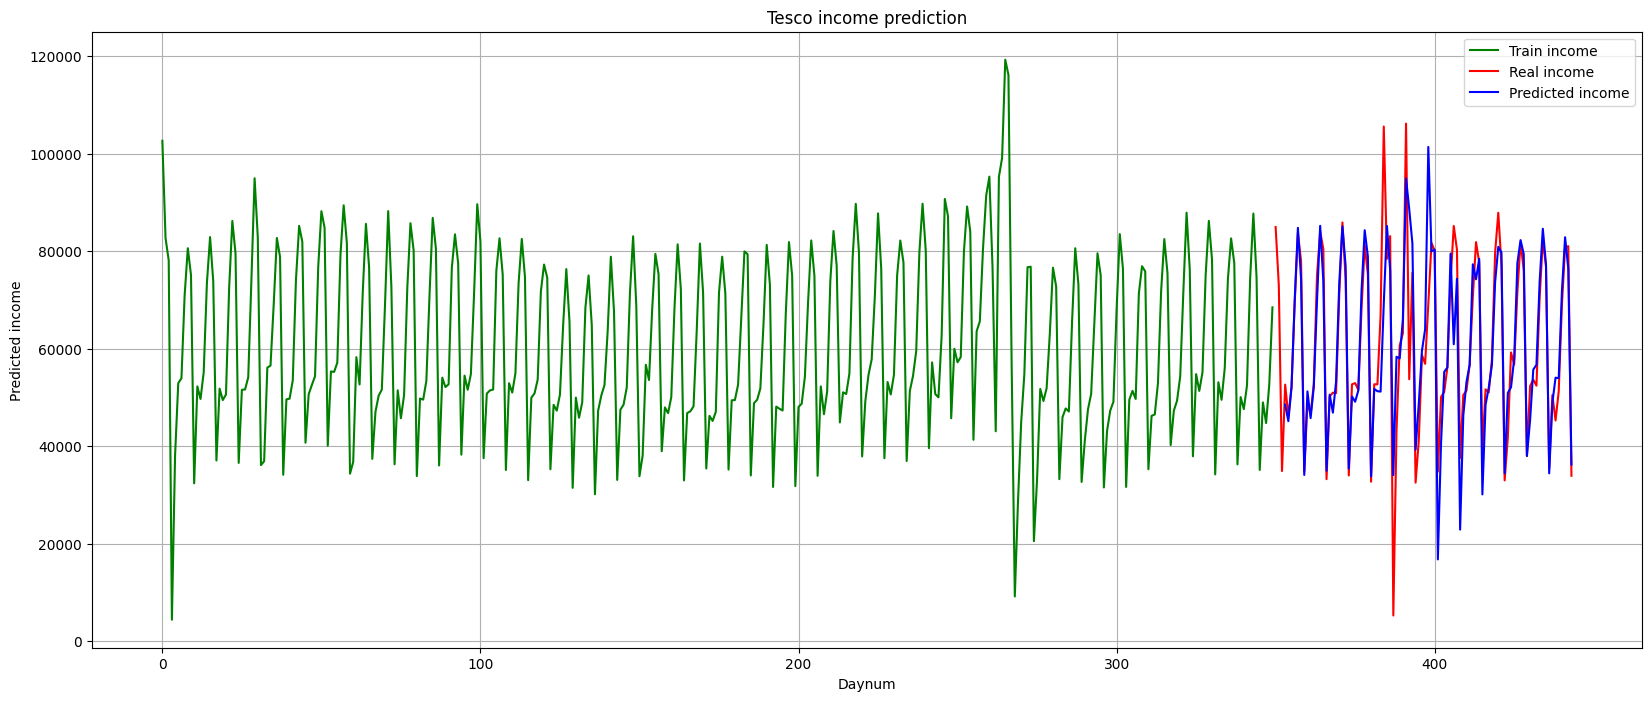

In [354]:
# evaluate forecasts simple model
plt.figure(figsize=(20,8))
plt.plot(cust_df.index[0:350], cust_df['day_spend'].head(350), color='green', label = 'Train income')
plt.plot(test_df.index, test_df['day_spend'], color = 'red', label = 'Real income')
plt.plot(test_df.index[3:], pred3, color = 'blue', label = 'Predicted income')
plt.title('Tesco income prediction')
plt.xlabel('Daynum')
plt.ylabel('Predicted income')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

In [371]:
# report all performance

perf = list()
perf2 = list()
perf3 = list()
perf_simple= list()
for i in range (0,13):
    print('Week '+str(i+1)+' MAE: '+str(mean_absolute_error(test[i*7:(i+1)*7], pred[i*7:(i+1)*7])))
    print('Week '+str(i+1)+' RMSE: '+str(math.sqrt(mean_squared_error(test[i*7:(i+1)*7], pred3[i*7:(i+1)*7]))))
    perf.append(math.sqrt(mean_squared_error(test[i*7:(i+1)*7], pred[i*7:(i+1)*7])))
    
    print('Week '+str(i+1)+' MAE: '+str(mean_absolute_error(test[i*7:(i+1)*7], pred2[i*7:(i+1)*7])))
    print('Week '+str(i+1)+' RMSE: '+str(math.sqrt(mean_squared_error(test[i*7:(i+1)*7], pred3[i*7:(i+1)*7]))))
    perf2.append(math.sqrt(mean_squared_error(test[i*7:(i+1)*7], pred2[i*7:(i+1)*7])))
    
    print('Week '+str(i+1)+' MAE: '+str(mean_absolute_error(test[i*7:(i+1)*7], pred3[i*7:(i+1)*7])))
    print('Week '+str(i+1)+' RMSE: '+str(math.sqrt(mean_squared_error(test[i*7:(i+1)*7], pred3[i*7:(i+1)*7]))))
    perf3.append(math.sqrt(mean_squared_error(test[i*7:(i+1)*7], pred3[i*7:(i+1)*7])))
    
    print('Week '+str(i+1)+' MAE: '+str(mean_absolute_error(test[i*7:(i+1)*7], predictions_simple[i*7:(i+1)*7])))
    print('Week '+str(i+1)+' RMSE: '+str(math.sqrt(mean_squared_error(test[i*7:(i+1)*7], pred3[i*7:(i+1)*7]))))
    perf_simple.append(math.sqrt(mean_squared_error(test[i*7:(i+1)*7], predictions_simple[i*7:(i+1)*7])))

Week 1 MAE: 1534.2559207990178
Week 1 RMSE: 2195.8842033055853
Week 1 MAE: 2357.285147166286
Week 1 RMSE: 2195.8842033055853
Week 1 MAE: 1615.546404093425
Week 1 RMSE: 2195.8842033055853
Week 1 MAE: 2451.635714285716
Week 1 RMSE: 2195.8842033055853
Week 2 MAE: 3164.607505985948
Week 2 RMSE: 3406.256341498474
Week 2 MAE: 3615.015724323327
Week 2 RMSE: 3406.256341498474
Week 2 MAE: 2603.8063307117586
Week 2 RMSE: 3406.256341498474
Week 2 MAE: 2653.845714285713
Week 2 RMSE: 3406.256341498474
Week 3 MAE: 2095.944170913296
Week 3 RMSE: 2332.4998792067045
Week 3 MAE: 2217.1719509411205
Week 3 RMSE: 2332.4998792067045
Week 3 MAE: 2017.5653981954674
Week 3 RMSE: 2332.4998792067045
Week 3 MAE: 2407.087142857145
Week 3 RMSE: 2332.4998792067045
Week 4 MAE: 2382.7428733039014
Week 4 RMSE: 2881.195521822849
Week 4 MAE: 1801.758317770201
Week 4 RMSE: 2881.195521822849
Week 4 MAE: 2555.0589776363645
Week 4 RMSE: 2881.195521822849
Week 4 MAE: 3803.1328571428558
Week 4 RMSE: 2881.195521822849
Week 5 MA

In [372]:
# make dataframe from the lists
perf_df = pd.DataFrame({'ARIMA':perf,'SARIMA':perf2,'ETS':perf3,'Simple':perf_simple})

In [ ]:
# write every row which column has the lower value
# the lower value means the better model
perf_df['Best'] = perf_df.idxmin(axis=1)

In [375]:
perf_df

,ARIMA,SARIMA,ETS,Simple,Best
0,1934.877174,2810.630196,2195.884203,2995.878991,ARIMA
1,3994.862782,4373.414288,3406.256341,3864.035301,ETS
2,2681.756451,2635.133663,2332.499879,2736.328048,ETS
3,2818.314500,2302.503511,2881.195522,4444.751331,SARIMA
4,19998.212188,19696.286904,18836.363883,18578.259140,Simple
5,14620.457078,16283.170255,15464.306250,18877.431690,ARIMA
6,13945.000587,11981.978982,14496.216115,18834.323442,SARIMA
7,8648.258524,11819.519864,11810.218694,17953.149248,ARIMA
8,9461.439844,5562.782522,5448.548753,4908.017550,Simple
9,6581.462495,6261.940567,3890.319940,3285.078271,Simple


Based on the RMSE the ARIMA will be the best model for forecasting
